## Generate Data using SAMMY

This notebook works to couple the (recently) open source SAMMY code from ORNL to calculate a RRR cross section. The advantage of coupling to SAMMY is its ability to efficiently apply experimental corrections.

In [1]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
# import nuctools

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
from ATARI.theory.xs import SLBW
from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions

In [2]:
%matplotlib widget

In [3]:
ac = 0.81271    # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})

Ta_pair.map_quantum_numbers(True)


The following arrays describe all possible spin groups for a each parity.
    The data is given as a tuple where the first value is the integer 
    or half integer total quantum spin J and the second value is the 
    number of entrance channels for that spin group. 
    * See the dictionary "possible_Jpi" for a nested packing structure.

Spin group data for all parity
(Jpi, #Chs, l-waves)
(-5.0, 1, [1])
(-4.0, 2, [1, 1])
(-3.0, 2, [1, 1])
(-2.0, 1, [1])
(3.0, 1, [0])
(4.0, 1, [0])


In [4]:
### calc calculate a full energy grid yourself 
# energy_grid = [75, 125]
energy_grid = [2e2, 2.5e2]

### or just give the min/max and the experiment object will do the above
# energy_grid = E_min_max

input_options = {'Add Noise': True,
            'Calculate Covariance': True,
            'Sample TURP': False}

experiment_parameters = {'bw': {'val':0.00192,    'unc'   :   0}} #,
                        #  'trigo': {'val':1e9,    'unc'   :   0},
                        #  'trigs': {'val':1e9,    'unc'   :   0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)
len(exp.energy_domain)

9891

In [5]:
spin_groups = [ (3.0,1,0) ]

# an alternative option would be to give Ta_pair.J, as long as you give an average parameter dataframe with corresponding indices
# spin_groups = Ta_pair.J

average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':4.17, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })
                                    
                                    
resonance_ladder = Ta_pair.sample_resonance_ladder(energy_grid, spin_groups, average_parameters)
# resonance_ladder = pd.read_csv("./UPR_presentation_ladder.csv")
# resonance_ladder.rename(columns={"gn2":"Gn1"}, inplace=True)

resonance_ladder

,E,Gg,gn2,J,chs,lwave,J_ID
0,205.347201,62.196459,36.312612,3.0,1.0,0.0,1.0
1,210.187770,68.220051,0.005269,3.0,1.0,0.0,1.0
2,211.206802,65.504878,41.275714,3.0,1.0,0.0,1.0
3,213.239962,64.726629,75.365645,3.0,1.0,0.0,1.0
4,218.011471,68.980196,0.456527,3.0,1.0,0.0,1.0
5,219.563857,64.105237,119.663124,3.0,1.0,0.0,1.0
6,223.583585,66.035987,0.032265,3.0,1.0,0.0,1.0
7,227.276566,66.949527,7.446124,3.0,1.0,0.0,1.0
8,228.333615,64.264296,1.905460,3.0,1.0,0.0,1.0
9,235.281028,64.301112,0.064393,3.0,1.0,0.0,1.0


### Calculate cross section using SAMMY and run experiment

In [22]:
sammyRTO = sammy_classes.SammyRunTimeOptions(
    path_to_SAMMY_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
    model = 'XCT',
    reaction = 'capture',
    solve_bayes = False,
    inptemplate= "allexpcap_1sg.inp",
    energy_window = None,
    sammy_runDIR = 'SAMMY_runDIR_1',
    keep_runDIR = True,
    shell = 'zsh',
    )

# resonance_ladder = pd.DataFrame({'E':[80.0], 'Gt':[16], 'Gn':[1], 'J':[3], 'chs':[1], 'lwave':[0], 'J_ID':[1]})
# resonance_ladder = pd.DataFrame({'E':[24.0], 'Gg':[7.0], 'Gn':[4.0], 'J':[3], 'chs':[1], 'lwave':[0], 'J_ID':[1]})


sammyINP = sammy_classes.SammyInputData(
    particle_pair = Ta_pair,
    resonance_ladder = resonance_ladder,
    energy_grid = exp.energy_domain,
    temp = 304.5,
    FP=35.185,
    frac_res_FP=0.049600,
    target_thickness=0.067166)

sammyOUT = sammy_functions.run_sammy(sammyINP, sammyRTO)
theo, par = sammyOUT.pw, sammyOUT.par


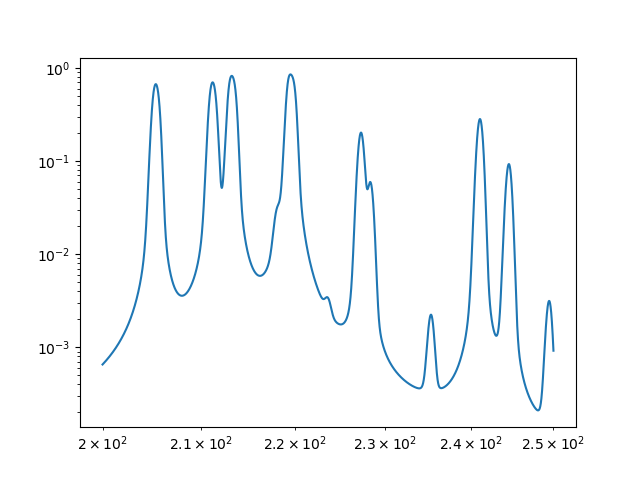

In [27]:
figure()
# plot(theo.E, theo.theo_xs/theo1.theo_xs)
plot(theo.E, theo.theo_xs)

# plot(theo.E, theo1.theo_xs)

xscale('log')
yscale('log')

In [57]:

exp.run(theo)
# exp.redpar - exp.theo_redpar

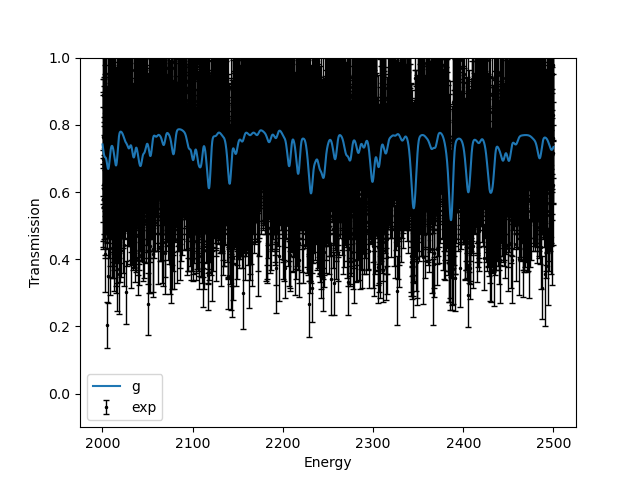

In [58]:
figure()
plot(theo.E, theo.theo_trans, ms=1, label='g')
errorbar(exp.trans.E, exp.trans.exp_trans, yerr=exp.trans.exp_trans_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

# plot(exp.trans.E, exp.trans.theo_trans, color='g', lw=1, label='Sol', zorder=2)

ylim([-.1, 1])
# xscale('log')
xlabel('Energy'); ylabel('Transmission')
legend()

In [22]:
# from ATARI.utils.datacontainer import DataContainer
# d = DataContainer()
# d.add_theoretical(Ta_pair, resonance_ladder)
# d.add_experimental(exp)
# d.fill()


# figure(figsize=(6,5))

# errorbar(d.pw_exp.E, d.pw_exp.exp_xs, yerr=d.pw_exp.exp_xs_unc, zorder=2,
#                                 fmt='.', color='k', ecolor='k', linewidth=0.5, markersize=3.5, capsize=2, label='exp')
# # 

# plot(theo.E, theo.theo_xs, color='r', zorder=0, lw=3)

# # xlim([2501,2990])
# yscale('log')
# xscale('log')
# ylabel(r'$\sigma_{total}$', fontsize=15)
# xlabel('Energy (eV)', fontsize=15)
# title('Ta-181 Cross Section', fontsize=16)

# tight_layout()

## Generating many sets of data

The Module for Mass Data Acquisition (MMDA) can be used to conveniently generate multiple different sets of data. An example is shown below. The case_directory will house data from each sample in a systematic/organized way.

Note: the particle pair object you pass to MMDA must have spin groups and average parameters defined upon instantiation

In [23]:


case_file = './MMDA_data.hdf5'  # if using hdf5

dataset_range = (0, 10)
spin_groups = [ (3.0,1,0) ]
Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )    

samples_not_generated = generate(Ta_pair, exp, 
                                        'sammy', 
                                        dataset_range, 
                                        case_file,
                                        fixed_resonance_ladder=resonance_ladder, 
                                        open_data=None,
                                        vary_Erange=None,
                                        use_hdf5=True,
                                        overwrite = True,
                                        sammy_RTO=sammyRTO,
                                        sammy_INP=sammyINP
                                                                    )


(-0.1, 1.0)

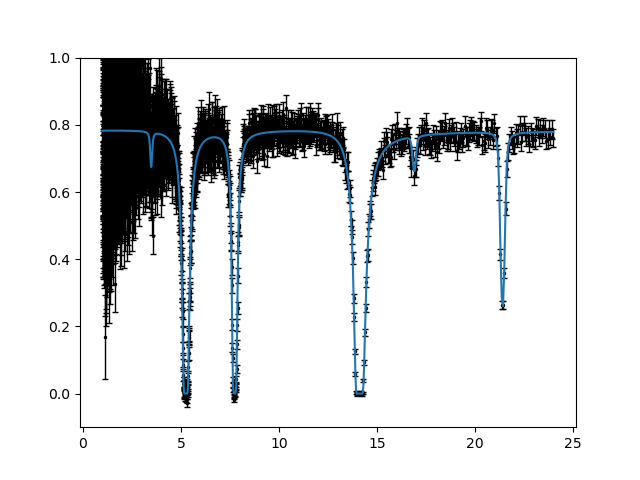

In [27]:
import ATARI.utils.atario as aio

isample = 3
exp_pw, exp_cov = aio.h5read_experimental(case_file, isample)
# theo_pw, theo_par = aio.h5read_theoretical(case_file, isample)  #for fine grid theoretical

figure()
plot(exp_pw.E, exp_pw.theo_trans, ms=1, label='g')
errorbar(exp_pw.E, exp_pw.exp_trans, yerr=exp_pw.exp_trans_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

# xscale('log')
ylim([-.1, 1])